# Prism Initial ETA

In [25]:
# Python required libraries
#----------------------------
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import mlab

import warnings
warnings.filterwarnings("ignore")

# Loading the Data

In [26]:
# Loading data(1 month data)
#-------------------
df_CSV = pd.read_csv('../CSV/Prism/prism.csv', header=None, engine='python')

In [27]:
# Checking data
#-----------------
print("shape of Data= ", df_CSV.shape)
df_CSV.head(3)

shape of Data=  (1022461, 10)


,0,1,2,3,4,5,6,7,8,9
0,ï»¿F400A985-F59C-42D0-8CDA-48840859F699,82902558,CO,JEFFERSON,county,criminal,2019-03-30 19:07:45.410,2019-03-30 19:08:58.313,Hit,FDI_CO_MC_COCOURTS
1,6DBE2AEE-2452-4046-8130-0BB1C10EB334,82902588,OK,POTTAWATOMIE,county,criminal,2019-03-30 19:07:57.053,2019-03-30 19:09:03.137,Clear,FDI_OK_MC_ODCR_SMD
2,A9F22C36-5C6B-4922-A583-6CCEC535B8B6,151553713,CA,NEVADA,county,criminal,2019-03-30 14:28:58.713,2019-03-30 14:50:43.620,Clear,QC_CA_NEVADA


In [28]:
# Assgning the column names
#---------------------------
df_CSV.columns = ["ScreeningID", "IFN_ID", "State", "County", "ScreeningQualifier", "ScreeningType", "StartDateTime", "PublishDateTime", "ResultStatus", "Vendor"]

# Data Preprocessing

In [29]:
# Checking null values
#---------------------
df_CSV.isnull().sum()

ScreeningID           0
IFN_ID                0
State                 0
County                0
ScreeningQualifier    0
ScreeningType         0
StartDateTime         0
PublishDateTime       0
ResultStatus          0
Vendor                0
dtype: int64

In [30]:
# Removing in any null values
#----------------------------------
df_CSV = df_CSV.dropna(subset=['State', 'County', 'StartDateTime', 'PublishDateTime'])

In [31]:
# Merging state and County as a new feature, to avoid duplications of county with different states
# Making all the text values as lower case, to avoid any confusion
#------------------------------------
df_CSV['State'] = df_CSV['State'].str.lower()
df_CSV['State'] = df_CSV['State'].str.strip()

df_CSV['County'] = df_CSV['County'].str.lower()
df_CSV['County'] = df_CSV['County'].str.strip()

df_CSV['County'] = df_CSV['County'].str.replace(' lower', '')  # To replace lower and upper county names with Base name---

# Replacing Saint and Sainte with short forms-----
df_CSV['County'] = df_CSV['County'].str.replace('saint ', 'st ')
df_CSV['County'] = df_CSV['County'].str.replace('sainte ', 'ste ')


# Ignoring county with 'l2 individual' name-------
df_CSV = df_CSV[df_CSV.County != 'l2 individual']

# Merging state and county-------
df_CSV['State-County']  = df_CSV['State'] +"_" + df_CSV['County']


In [32]:
# Repeating the above process for vendor feature
# Vendor
#-----------
df_CSV['Vendor'] = df_CSV['Vendor'].str.lower()
df_CSV['Vendor'] = df_CSV['Vendor'].str.strip()

In [33]:
# Product Name
# Checking ScreeningQualifier and ScreeningType
#------------------------------------
df_CSV['ScreeningQualifier'] = df_CSV['ScreeningQualifier'].str.lower()
df_CSV['ScreeningType'] = df_CSV['ScreeningType'].str.lower()

print("ScreeningQualifier", df_CSV["ScreeningQualifier"].unique())
print("ScreeningType", df_CSV["ScreeningType"].unique())

# Note: getting ScreeningQualifier --> 'county' and ScreeningType --> 'Criminal

ScreeningQualifier ['county']
ScreeningType ['criminal']


In [34]:
# ETA ( Minutes )
#------------------
import datetime

df_CSV['StartDateTime'] = pd.to_datetime(df_CSV['StartDateTime'])
df_CSV['PublishDateTime'] = pd.to_datetime(df_CSV['PublishDateTime'])

df_CSV['ETA'] = df_CSV['PublishDateTime'] - df_CSV['StartDateTime']

df_CSV['ETA'] = df_CSV['ETA'].dt.total_seconds().div(60).astype(int)  # Converting into minutes---

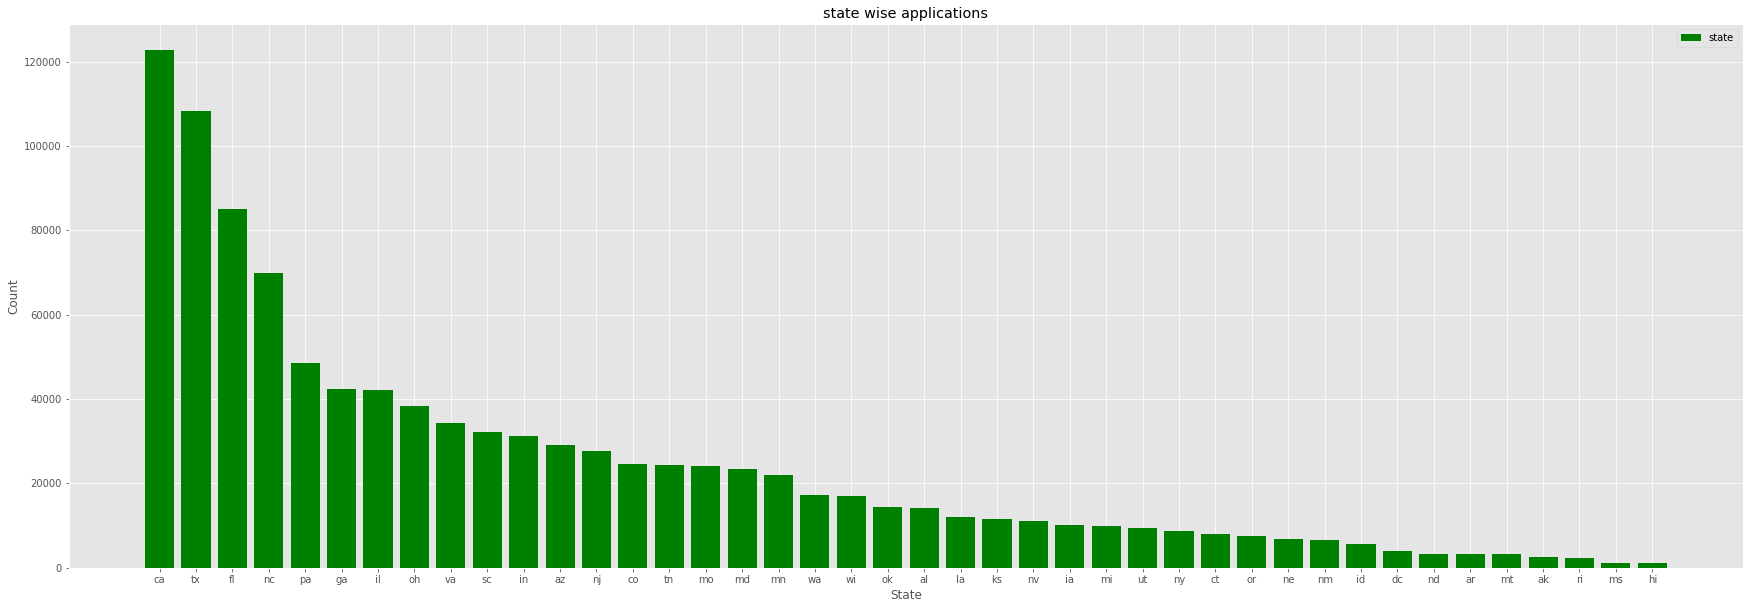

In [35]:
# PLoting state wise counts
#----------------------------

data_state = pd.DataFrame(df_CSV.State.value_counts().reset_index())
data_state.columns = ['State', 'Count']
data_state.head()
data_state.shape

import matplotlib.pyplot as plt  
from matplotlib import style

style.use("ggplot")

x = data_state['State']
y = data_state['Count']

plt.figure(figsize=(30,10))

plt.title("state wise applications")   #Title of graph----
plt.xlabel('State')    # x-labe
plt.ylabel('Count')    # y-label


# Plot the points using matplotlib 
plt.bar(x, y, color='green', label="state")  # Ploting the graph---

plt.legend()
#plt.grid(True, color="k")
plt.show()


In [36]:
# Removing Observations which are having less than 20 requests
# To avoid bias of data
# Later we will get more data for these many state-county combination
#---------------------------------------------------------
dfRemove_StateCounts = df_CSV['State-County'].value_counts()
print("Unique State-county = ", dfRemove_StateCounts.shape[0])

dfRemove_StateCounts = dfRemove_StateCounts[dfRemove_StateCounts < 20]
print("Unique State-county having less than 20 observations/requests = ", dfRemove_StateCounts.shape[0])
#--------------------------------------------------

df_CSV = df_CSV[~df_CSV['State-County'].isin(dfRemove_StateCounts.index)]
#df_CSV.shape

Unique State-county =  2025
Unique State-county having less than 20 observations/requests =  321


In [37]:
# Cross Checking the staes name from our glossary list
# ----------------------------------------

df_State_County_CSV = pd.read_csv('../CSV/US_StateCounty.csv')


# Checking for valid State -----------------------

state_list = df_State_County_CSV['Abbr'].unique()

print("Total States = ", len(state_list))

# Keepig only state list which are valid----

#state_list = [str(item).lower() for item in state_list]
state_list = [x.lower() for x in state_list]

print("state_list = ", state_list)

df_CSV = df_CSV[df_CSV['State'].isin(state_list)]


df_CSV.shape

Total States =  50
state_list =  ['al', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'de', 'fl', 'ga', 'hi', 'id', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma', 'mi', 'mn', 'ms', 'mo', 'mt', 'ne', 'nv', 'nh', 'nj', 'nm', 'ny', 'nc', 'nd', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy']


(1015405, 12)

In [38]:
# Checking for County names from our Glossary
#-------------------------------------------

lsCounty = df_State_County_CSV['County']
lsCounty = [item.lower() for item in lsCounty]

df_Missing_County = df_CSV[~df_CSV['County'].isin(lsCounty)]

df_Missing_County['County'].unique()

print("Not matching state and county from Glossary----")
df_Missing_County[['State','County']]
#df_Missing_County['County'].unique()

Not matching state and county from Glossary----


,State,County


In [39]:
# Analyzing Different Product ex: Criminal, Civil etc
# Note: Currently we are predicting ETA for Criminal verification only
#-------------------------------------------
print("ScreeningType and counts = ", df_CSV["ScreeningType"].value_counts())

try:
    df_CSV = df_CSV[df_CSV["ScreeningType"]=="criminal"]

except:
    print("No criminal data found")



ScreeningType and counts =  criminal    1015405
Name: ScreeningType, dtype: int64


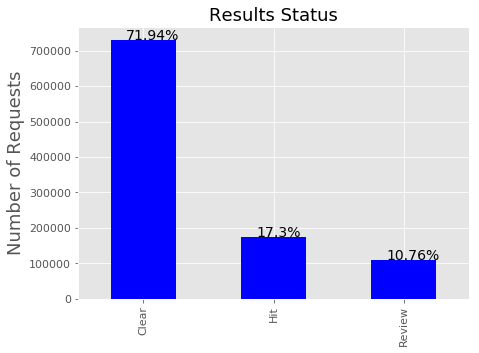

In [40]:
# Visualize prism results Percentage(Hit, Clear, Request)
#-------------------------------------------------------
ax = df_CSV['ResultStatus'].value_counts().plot(kind='bar', figsize=(7,5),
                                                  color="blue", fontsize=11);

ax.set_alpha(0.5)
ax.set_title("Results Status", fontsize=18)
ax.set_ylabel("Number of Requests", fontsize=18);
#ax.set_yticks([0, 5, 10, 15, 20, 25, 30, 35, 40])

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())
    
    
# set individual bar lables using above list
total = sum(totals)
total

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.12, i.get_height()+10, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=14,
                color='black')




# Split Hit and Clear

In [41]:
# Seprating The clear and hit datasets
#---------------------------------
print("Unique = ", df_CSV['ResultStatus'].unique())

df_CSV['ResultStatus'] = df_CSV['ResultStatus'].str.lower()

df_CSV_Clear = df_CSV[df_CSV['ResultStatus']== 'clear']
df_CSV_Hit = df_CSV[df_CSV['ResultStatus']== 'hit']
df_CSV_Review = df_CSV[df_CSV['ResultStatus']== 'review']

print("df_CSV = ", df_CSV.shape)
print("df_CSV_Clear = ", df_CSV_Clear.shape)
print("df_CSV_Hit = ", df_CSV_Hit.shape)
print("df_CSV_Review = ", df_CSV_Review.shape)

Unique =  ['Hit' 'Clear' 'Review']
df_CSV =  (1015405, 12)
df_CSV_Clear =  (730496, 12)
df_CSV_Hit =  (175640, 12)
df_CSV_Review =  (109269, 12)


In [42]:
# Saving Clear, Hit and Review CSV
#--------------------------------------

df_CSV_Clear.to_csv('../CSV/Prism/prism_clear.csv', index=False)
df_CSV_Hit.to_csv('../CSV/Prism/prism_hit.csv', index=False)
df_CSV_Review.to_csv('../CSV/Prism/prism_review.csv', index=False)


In [584]:
# -------------------------------------

# Save The Results in State-County Excel

In [43]:
df_State_County_CSV = pd.read_csv('../CSV/US_StateCounty.csv')
df_State_County_CSV.head(2)

,State,County,Abbr
0,Alabama,Autauga,AL
1,Alabama,Baldwin,AL


In [48]:
# To convert into lower case
#--------------------------------
df_State_County_CSV['State'] = df_State_County_CSV['State'].str.lower()
df_State_County_CSV['State'] = df_State_County_CSV['State'].str.strip()

df_State_County_CSV['County'] = df_State_County_CSV['County'].str.lower()
df_State_County_CSV['County'] = df_State_County_CSV['County'].str.strip()

df_State_County_CSV['Abbr'] = df_State_County_CSV['Abbr'].str.lower()
df_State_County_CSV['Abbr'] = df_State_County_CSV['Abbr'].str.strip()


df_State_County_CSV['State-County']= df_State_County_CSV['Abbr'] + "_" + df_State_County_CSV['County']

In [49]:
df_State_County_CSV.to_csv('../CSV/Prism/Output/prism.csv', index=False)